In [1]:
import os
import random
import numpy as np
import pandas as pd

import torch
# Модуль для построения нейросетей
import torch.nn as nn
# Все, что связано с функциями (функции потерь, активации и пр.)
import torch.nn.functional as F
# Оптимизаторы из торча достаем
import torch.optim as optim
# DataLoader позволяет загружать данные из Dataset и имеет различные функции (Shuffle, Batching, Multiprocessing)
from torch.utils.data import DataLoader, Dataset

# Красивый прогресс-бар
from tqdm.notebook import tqdm

# classification_report - сводная таблица со всеми метриками
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split

# Очистка результата выполнения функции display  и отрисовки только актуального значения
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

# Нормализация данных
from sklearn.preprocessing import StandardScaler

# Установка общего стиля графиков seaborn
sns.set_theme()

# 0. Обеспечение воспроизводимости

In [2]:
# Устанавливаем random_seed там, где это только возможно
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")

set_seed(42)

Random seed set as 42


# 1. Загрузка датасета

In [3]:
url = 'https://github.com/pacifikus/itmo_dl_course/raw/master/HW/hw_1/cybersequrity.csv'
df = pd.read_csv(url)
df.head()

,svcscan.fs_drivers,callbacks.ngeneric,psxview.not_in_eprocess_pool_false_avg,psxview.not_in_eprocess_pool,callbacks.nanonymous,psxview.not_in_session,psxview.not_in_pslist,psxview.not_in_pspcid_list,psxview.not_in_ethread_pool,psxview.not_in_csrss_handles,psxview.not_in_pslist_false_avg,psxview.not_in_pspcid_list_false_avg,psxview.not_in_deskthrd,psxview.not_in_ethread_pool_false_avg,psxview.not_in_session_false_avg,Class
0,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.044444,1
1,26,8,0.0,0,0,5,3,3,3,7,0.073171,0.073171,9,0.073171,0.121951,1
2,26,8,0.0,0,0,9,7,7,7,11,0.152174,0.152174,13,0.152174,0.195652,1
3,26,8,0.0,0,0,3,1,1,2,6,0.022222,0.022222,9,0.044444,0.066667,1
4,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.048780,0


In [4]:
df.shape

(10000, 16)

# 2. Подготовка данных

## 2.1 Разделение на TVT

In [5]:
# В датафрейме X убираем целевую переменную, y - наша целевая переменная
X, y = df.drop('Class', axis=1), df['Class']
# Делим исходный датасет на обучающую и тестовую части
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42, stratify = y)
# И уже далее формируем валидационную выборку из тестовой
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.50, random_state = 42, stratify = y_test)

In [6]:
scaler = StandardScaler()

# Применяем StandardScaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

## 2.2 Обертка данных

In [7]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        # X - датафрейм, X.values - это просто массив всех значений, мы его превращаем в тензор
        self.X = torch.Tensor(X)
        # Для таргета немного по-другому, reshape(-1, 1) - минус один означает вот сколько там элементов, столькими строками и заполнить;
        # Один - значит одна колонка
        self.y = torch.from_numpy(y.values).reshape(-1, 1).float()
        
    def __len__(self):
        # Возвращаем количество строк
        return self.X.shape[0]
        
    def __getitem__(self, index):
        # Получаем композицию (признак + таргет)
        return (self.X[index], self.y[index])


In [8]:
train_dataset = CustomDataset(X_train_scaled, y_train)
val_dataset = CustomDataset(X_val_scaled, y_val)
test_dataset = CustomDataset(X_test_scaled, y_test)

In [352]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# Shuffle = False для обеспечения воспроизводимости
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 3. Реализация нейросети

In [353]:
class CyberSecurityNNold(nn.Module):
    def __init__(self, num_labels, input_size, hidden_sizes, activation):
        """
        num_labels: количество выходных нейронов (для бинарной классификации — 1).
        input_size: количество входных признаков.
        hidden_sizes: список размеров скрытых слоев (например, [64, 32, 16]).
        activation: функция активации (например, nn.ReLU).
        """
        super(CyberSecurityNNold, self).__init__()
        
        # Проверяем, что hidden_sizes — это список
        if not isinstance(hidden_sizes, list):
            raise ValueError("hidden_sizes должен быть списком размеров скрытых слоев.")
        
        # Инициализация списка слоев
        layers = []
        
        # Первый слой: входной слой -> первый скрытый слой
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(activation())
        
        # Добавляем оставшиеся скрытые слои
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(activation())
        
        # Последний слой: последний скрытый слой -> выходной слой
        layers.append(nn.Linear(hidden_sizes[-1], num_labels))
        
        # Собираем все слои в Sequential
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        # Применяем сигмоиду только на выходе
        y_pred = torch.sigmoid(self.layers(x))
        return y_pred

# 4. Первичная инициализация

In [354]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Для бейзлайна возьмем данные параметры, взяли распространенную эффективную и простую функцию активации ReLU

In [360]:
# Гиперпараметры

input_size = 15  # количество входных признаков (без таргета!)
hidden_sizes = [25, 25] # количество нейронов на скрытом слое
num_labels = 1   # бинарный выход
activation = nn.ReLU  # активация
learning_rate = 0.01 # скорость обучения
num_epochs = 100

In [361]:
# Создаем модель с нашими параметрами
model = CyberSecurityNNold(num_labels=num_labels, input_size=input_size, hidden_sizes=hidden_sizes, activation=activation)
# Помещаем в наш девайс
model = model.to(device)

In [362]:
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss, т.к. классификация бинарная
optimizer = optim.Adam(model.parameters(), lr = learning_rate) # Определяем оптимизатор

# 5. Цикл обучения

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 0.6550, Val Loss: 0.6257
Epoch [2/100], Train Loss: 0.5846, Val Loss: 0.5540
Epoch [3/100], Train Loss: 0.5233, Val Loss: 0.4950
Epoch [4/100], Train Loss: 0.5044, Val Loss: 0.4779
Epoch [5/100], Train Loss: 0.4862, Val Loss: 0.5290
Epoch [6/100], Train Loss: 0.4871, Val Loss: 0.4648
Epoch [7/100], Train Loss: 0.4907, Val Loss: 0.5091
Epoch [8/100], Train Loss: 0.4847, Val Loss: 0.4568
Epoch [9/100], Train Loss: 0.4851, Val Loss: 0.5046
Epoch [10/100], Train Loss: 0.4738, Val Loss: 0.5062
Epoch [11/100], Train Loss: 0.4751, Val Loss: 0.4949
Epoch [12/100], Train Loss: 0.4861, Val Loss: 0.5116
Epoch [13/100], Train Loss: 0.4746, Val Loss: 0.4778
Epoch [14/100], Train Loss: 0.4702, Val Loss: 0.4681
Epoch [15/100], Train Loss: 0.4657, Val Loss: 0.4569
Epoch [16/100], Train Loss: 0.4521, Val Loss: 0.4601
Epoch [17/100], Train Loss: 0.4494, Val Loss: 0.4556
Epoch [18/100], Train Loss: 0.4609, Val Loss: 0.4302
Epoch [19/100], Train Loss: 0.4515, Val Loss: 0.4696
Ep

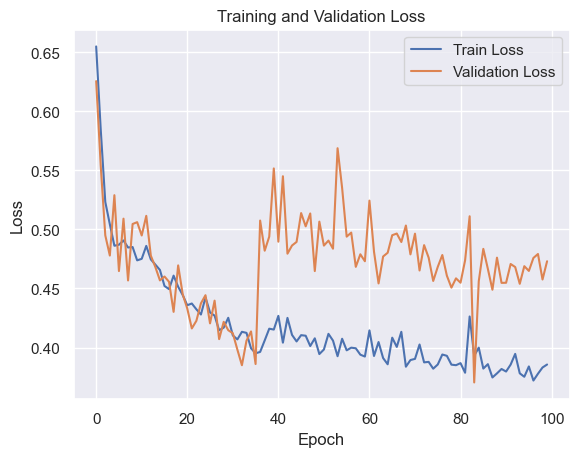

In [363]:
# Собираем наши лоссы для каждого шага
train_losses = []
val_losses = []

# Обучение (train-loop)
for epoch in tqdm(range(num_epochs)):
    # Переводим в режим обучения, см. подробнее: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch
    model.train()
    # Считаем общий лосс, чтобы потом вычислять среднее
    running_train_loss = 0.0

    # Для признаков и таргетов
    for inputs, labels in train_dataloader:
        # Помещаем в наш девайс, это один батч у нас
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass (т.е. наши данные проходят через модель (с текущими весами) и затем смотрим на лосс, как часто модель ошибалась)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass и обновление весов
        # Обнуляем градиенты, которые уже не актуальны
        optimizer.zero_grad()
        # Обратный проход по структуре
        loss.backward()
        # Обновление весов
        optimizer.step()
        # Суммируем лосс
        running_train_loss += loss.item()

    # Средняя функция потерь на тренировочной выборке за эпоху, чтобы не зависеть от аномалий всякого рода
    train_loss = running_train_loss / len(train_dataloader)
    # Добавляем тренировочный лосс
    train_losses.append(train_loss)

    # Валидация (eval-loop)
    # Переводим в режим оценивания
    model.eval()
    running_val_loss = 0.0
    # Отключаем вычисление градиентов
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    # Средняя функция потерь на валидационной выборке за эпоху
    val_loss = running_val_loss / len(val_dataloader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Визуализация функции потерь
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 6. Оценка точности предсказаний

In [364]:
from sklearn.metrics import classification_report

# Тестирование модели
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs).squeeze()
        preds = (outputs > 0.5).long()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Построение отчета о классификации
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

         0.0       0.77      0.91      0.83       981
         1.0       0.90      0.74      0.81      1019

    accuracy                           0.82      2000
   macro avg       0.83      0.82      0.82      2000
weighted avg       0.83      0.82      0.82      2000



До этого пункта эмпирически уже были подобраны гиперпараметры, но ничего с сильно лучшими результатами не получилось...

<div style="text-align: center;">
    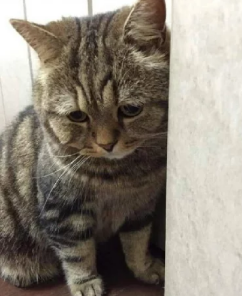
</div>

# 7. Улучшение архитектуры нейросети

Зададим новые гиперпараметры. В частности, для применения BatchNorm лучше использовать бОльший размер батчей

In [365]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# Shuffle = False для обеспечения воспроизводимости
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

- Эмпирически дошел до того, что структура должна быть сжимающейся (128->64->32->16)
- Уменьшил lr
- Оставил ту же функцию активации

In [366]:
input_size = 15  # количество входных признаков (без таргета!)
hidden_sizes = [128, 64, 32, 16] # количество нейронов на скрытом слое
num_labels = 1  # бинарный выход
activation = nn.ReLU  # активация
learning_rate = 0.001 # скорость обучения
num_epochs = 100

dropout_prob = 0.1 \
бОльшие значения вероятности делают метрики хуже \
Порядок слоев, который показывает лучшие метрики: activation -> batch_norm -> dropout

In [372]:
class CyberSecurityNN(nn.Module):
    # num_labels - количество выходных нейронов, для данной задачи (0, 1)
    # input_size - количество входных нейронов, входных параметров
    # n_linear_layers - количество слоев нейросети
    # activation - функция активации
    # dropout_prob - веороятность, с которой мы "дропнем" определенный нейрон
    
    def __init__(self, num_labels, input_size, hidden_sizes, activation=nn.ReLU, dropout_prob = 0.1):
        
        # Надо не забыть вызвать конструктор базового класса, т.к. что-то может не проинициализироваться
        super(CyberSecurityNN, self).__init__()
        
        # Инициализация списка слоев
        layers = []
        
        # Первый слой: входной слой -> первый скрытый слой
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(activation())
        layers.append(nn.BatchNorm1d(hidden_sizes[0]))  # BatchNorm для первого слоя
        layers.append(nn.Dropout(dropout_prob))  # Dropout для первого слоя
        
        # Добавляем оставшиеся скрытые слои
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(activation())
            layers.append(nn.BatchNorm1d(hidden_sizes[i]))  # BatchNorm
            layers.append(nn.Dropout(dropout_prob))  # Dropout
        
        # Последний слой: последний скрытый слой -> выходной слой
        layers.append(nn.Linear(hidden_sizes[-1], num_labels))
        
        # Собираем все слои в Sequential
        self.layers = nn.Sequential(*layers)

    # x - вход для нейросети
    def forward(self, x):
        
        # На выходе (только на выходе!!!) преобразуем в [0, 1]
        y_pred = torch.sigmoid(self.layers(x))
        # Выдаем результаты прогноза нейросети 
        return y_pred
        

In [373]:
# Создаем модель с нашими параметрами
model = CyberSecurityNN(num_labels=num_labels, input_size=input_size, hidden_sizes = hidden_sizes, activation=activation)
# Помещаем в наш девайс
model = model.to(device)

In [374]:
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss, т.к. классификация бинарная
optimizer = optim.Adam(model.parameters(), lr = learning_rate) # Определяем оптимизатор

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 0.6380, Val Loss: 0.6227
Epoch [2/100], Train Loss: 0.5548, Val Loss: 0.5624
Epoch [3/100], Train Loss: 0.5148, Val Loss: 0.5293
Epoch [4/100], Train Loss: 0.4918, Val Loss: 0.5132
Epoch [5/100], Train Loss: 0.4757, Val Loss: 0.5030
Epoch [6/100], Train Loss: 0.4668, Val Loss: 0.4964
Epoch [7/100], Train Loss: 0.4635, Val Loss: 0.4852
Epoch [8/100], Train Loss: 0.4392, Val Loss: 0.4604
Epoch [9/100], Train Loss: 0.4491, Val Loss: 0.5616
Epoch [10/100], Train Loss: 0.4539, Val Loss: 0.4876
Epoch [11/100], Train Loss: 0.4429, Val Loss: 0.4679
Epoch [12/100], Train Loss: 0.4223, Val Loss: 0.4596
Epoch [13/100], Train Loss: 0.4184, Val Loss: 0.4502
Epoch [14/100], Train Loss: 0.4219, Val Loss: 0.4495
Epoch [15/100], Train Loss: 0.4149, Val Loss: 0.4347
Epoch [16/100], Train Loss: 0.4066, Val Loss: 0.4218
Epoch [17/100], Train Loss: 0.4041, Val Loss: 0.4665
Epoch [18/100], Train Loss: 0.4163, Val Loss: 0.4467
Epoch [19/100], Train Loss: 0.4136, Val Loss: 0.4749
Ep

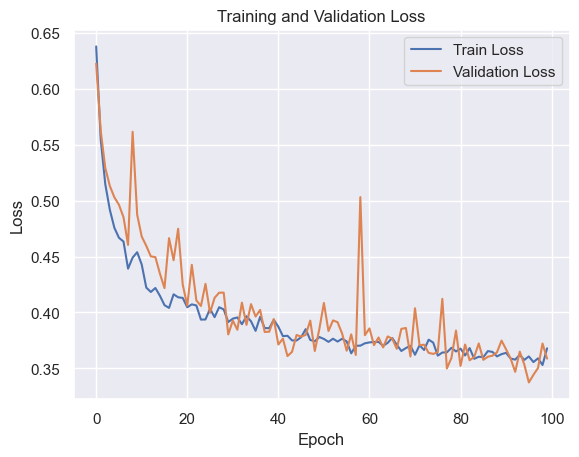

In [375]:
# Собираем наши лоссы для каждого шага
train_losses = []
val_losses = []

# Обучение (train-loop)
for epoch in tqdm(range(num_epochs)):
    # Переводим в режим обучения, см. подробнее: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch
    model.train()
    # Считаем общий лосс, чтобы потом вычислять среднее
    running_train_loss = 0.0

    # Для признаков и таргетов
    for inputs, labels in train_dataloader:
        # Помещаем в наш девайс, это один батч у нас
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass (т.е. наши данные проходят через модель (с текущими весами) и затем смотрим на лосс, как часто модель ошибалась)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass и обновление весов
        # Обнуляем градиенты, которые уже не актуальны
        optimizer.zero_grad()
        # Обратный проход по структуре
        loss.backward()
        # Обновление весов
        optimizer.step()
        # Суммируем лосс
        running_train_loss += loss.item()

    # Средняя функция потерь на тренировочной выборке за эпоху, чтобы не зависеть от аномалий всякого рода
    train_loss = running_train_loss / len(train_dataloader)
    # Добавляем тренировочный лосс
    train_losses.append(train_loss)

    # Валидация (eval-loop)
    # Переводим в режим оценивания
    model.eval()
    running_val_loss = 0.0
    # Отключаем вычисление градиентов
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    # Средняя функция потерь на валидационной выборке за эпоху
    val_loss = running_val_loss / len(val_dataloader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Визуализация функции потерь
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [376]:
from sklearn.metrics import classification_report

# Тестирование модели
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs).squeeze()
        preds = (outputs > 0.5).long()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Построение отчета о классификации
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

         0.0       0.80      0.90      0.84       981
         1.0       0.89      0.78      0.83      1019

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



# Выводы

По всей видимости, уменьшение количества нейронов от слоя к слою (128 -> 64 -> 32 -> 16) помогает модели постепенно "сжимать" информацию, что хорошо сказывается на метриках конечных




Используемая структура:

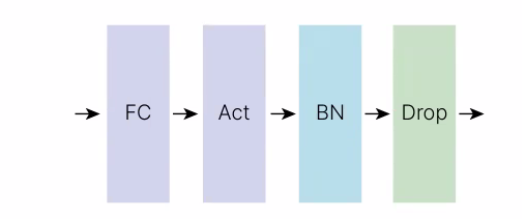